# An analysis of the State of the Union speeches - k nearest neighbors

In this notebook, you should explore one question or idea of your own from this dataset.  Provide the code and computations here, and summarize your points in the [main](main.ipynb) notebook.

# K-Nearest Neighbors 

In our previous notebooks, we've turned each speech in the dataset into a vector in $\mathbb{R}^{n}$ where $n$ is the number of words across all of the speeches. Each speech vector $\vec{v} \in \mathbb{R}^{n}$ represents a *count* of the number of occurrences of a particular word in that speech. For example, if George Washington's first state of the union used the word "America" 12 times, then the corresponding entry in that speech's vector would have a value of $12$. 

We want to use this data representation to train a classification algorithm known as **k-nearest neighbors**. We use a training set consisting of some of the Presidential speeches to train the algorithm. The vectors correspond to the data points, which the President who delivered the speech is the class label (so we have 45 class labels in total). Now, the algorithm has a set of "speeches" in $\mathbb{R}^{n}$, each of which is labeled with a speaker. 

When predicting the speaker of a speech outside the training dataset, the algorithm looks the $k$ (say, 4$) "nearest" neighbors in this high-dimensional space and takes a vote amongst their labels. For example, the 4 nearest neighbors of a test data point might have labels George Washington, George Washington, George Washington, and Thomas Jefferson. The algorithm takes a plurality vote of the k-nearest neighbors, which in this case indicates that George Washington is most likely the person who delivered the speech. 

## Algorithmic Choices 

The k-nearest neighbors algorithm requires an integer choice of $k$, a notion of "distance" in the space being used (in our case, $\mathbb{R}^{n}$), and a way of weighting the labels of the nearest neighbors. While we explore different values of $k$ in "Grid Search" below, we fix the weighting method and distance metric in our analysis. 

1. **Inverse-distance weighting**: A naive approach to k-nearest neighbors is to look at the class labels of the k-nearest neighbors and then take a simple vote of these labels. Inverse distance weighting gives more preference to "closer" neighbors, since these are more 

2. **Choice of distance metric**: Typically one might use the $\ell_{2}$ norm $\mathbb{R}^{n}$ as a measure of distance. But since our word-vectors measure a discrete probability distribution over $n$ words, we felt that the Jensen-Shannon Distance made more sense as a measure of difference between speeches. 

## Pre-Processing

Here, we access the previous vectorized speech data, and pre-process by: 

1. Scaling the data so that the entries in each vector add up to $1$. This is necessary in a k-nearest neighbors algorithm because otherwise the distance from one vector to another is dominated by the components which happen to take on a larger range of values. This also lends itself to an intepretation of each vector as a discrete-valued probability distribution over $n$ outcomes - in this case, words.

2. Separating the data into a test and training set. The test set consists of 1 speech for each president, while the training set is all other speeches. 

First, let's load the data we already saved in pre-processing.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
import shelve

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

with shelve.open('results/vars3') as db:    
    all_uq_words = db['unique_words']
    vocab_list = db['vocab_list']

addresses_df = pd.read_hdf('results/df3.addresses_df_3.h5', 'addresses_df')
speech_matrix = pd.read_hdf('results/df3.speech_matrix_3.h5', 'speech_matrix')
wmat = pd.read_hdf('results/df3.h5', 'wmat')

Next, let's normalize it.

In [10]:
def normalize(X):
    """Standardize a matrix X"""
    return((X / X.sum(0)))


scale_to_sum_one = lambda vec: vec/sum(vec)

normalized_speeches = speech_matrix.iloc[:, 2:].apply(scale_to_sum_one, axis=0)
speech_matrix.update(normalized_speeches)

In [17]:
#separate into a training and test set, with labels and vector values.
#initialize training and test data to be empty copies of the speech dataframe
training_data = pd.DataFrame(columns=speech_matrix.columns, index=speech_matrix.index)
test_data = pd.DataFrame(columns=speech_matrix.columns, index=speech_matrix.index)

all_label_values = speech_matrix['President'].values
for name in set(all_label_values): 
    #select a random speech given by the president with NAME
    speeches = speech_matrix[speech_matrix['President'] == name]
    test_index = np.random.randint(len(speeches))
    test_speech = speeches.iloc[test_index]
    
    #append the test_speech to test_data
    test_data = test_data.append(test_speech)
    
    #append everything except the test_speech to the training data
    training_data = training_data.append(speeches.iloc[:test_index, :])
    training_data = training_data.append(speeches.iloc[test_index + 1: , :])

#Drop the rows of NaN from both dataframes
test_data = test_data.dropna()
training_data = training_data.dropna()

## Finding the best k

The number of neighbors to consider in k-nearest neighbors (that is, the value of $k$) is an important hyperparameter for which different choices might yield varying levels of accuracy. We do a search over $k \in \{1, 2, 3, 4\}$ to decide which $k$ best minimizes the test error. The error measure is simply the number of speeches that are correctly classified. 

First, we'll set up the algorithm.

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import entropy

'''We will use J-S divergence as the metric in K-Nearest Neighbors'''
def JSdiv(p, q):
    """Jensen-Shannon divergence.
    
    Compute the J-S divergence between two discrete probability distributions.
    
    Parameters
    ----------
    
    p, q : array
        Both p and q should be one-dimensional arrays that can be interpreted as discrete
        probability distributions (i.e. sum(p) == 1; this condition is not checked).
        
    Returns
    -------
    float
        The J-S divergence, computed using the scipy entropy function (with base 2) for
        the Kullback-Leibler divergence.
    """
    m = (p + q) / 2
    return (entropy(p, m, base=2.0) + entropy(q, m, base=2.0)) / 2

'''Returns the percentage of the predicted labels which match the actual labels, as 
well as a list of the misclassified labels. Actual_labels is a Pandas Series while 
predicted_labels is a list'''
def accuracy_rate(predicted_labels, actual_labels): 
    assert len(predicted_labels) == len(actual_labels), 'Different number of predictions than actual cases.'
    actual_labels = list(actual_labels)
    num_labels = len(predicted_labels)
    misclassified_presidents = []
    
    for i in range(len(predicted_labels)):
        if predicted_labels[i] != actual_labels[i]: 
            misclassified_presidents.append(actual_labels[i])

    accuracy_rate = (num_labels - len(misclassified_presidents))/num_labels
    return accuracy_rate, misclassified_presidents

'''Trains a k-nearest neighbor classifier using J-S divergence as a metric and weighting by 
inverse distance. Returns the rate of correct speaker classification - that is, the rate at which
the predicted speaker of a speech in the test dataset is the actual speaker.'''
def knn_train_and_predict(k, train_speeches, train_labels, test_speeches, test_labels): 
    #instantiate an instance of the model 
    model = KNeighborsClassifier(n_neighbors=k, weights='distance', metric=JSdiv)
    
    #fit the model on the training data   
    model.fit(train_speeches, train_labels)
    
    #predict on the test data
    prediction = model.predict(test_speeches)
    
    #compute accuracy rate 
    test_accuracy, misclassified_presidents = accuracy_rate(prediction, test_labels)
    return test_accuracy

Next, we'll look at the accuracy for different $k$.

In [30]:
training_copy = training_data.copy()
training_labels = training_copy['President']
training_points = training_copy.iloc[:, 2:]

test_copy = test_data.copy()
test_labels = test_copy['President']
test_points = test_copy.iloc[:, 2:]

In [31]:
k_accuracy = {}
for k in range(1, 5): 
    test_accuracy = knn_train_and_predict(k, training_points, training_labels, test_points, test_labels)
    print('Accuracy for k={} was {}'.format(k, test_accuracy))
    k_accuracy[k] = test_accuracy

Accuracy for k=1 was 0.7619047619047619
Accuracy for k=2 was 0.7619047619047619
Accuracy for k=3 was 0.7142857142857143
Accuracy for k=4 was 0.6666666666666666


Let's create a plot of these.

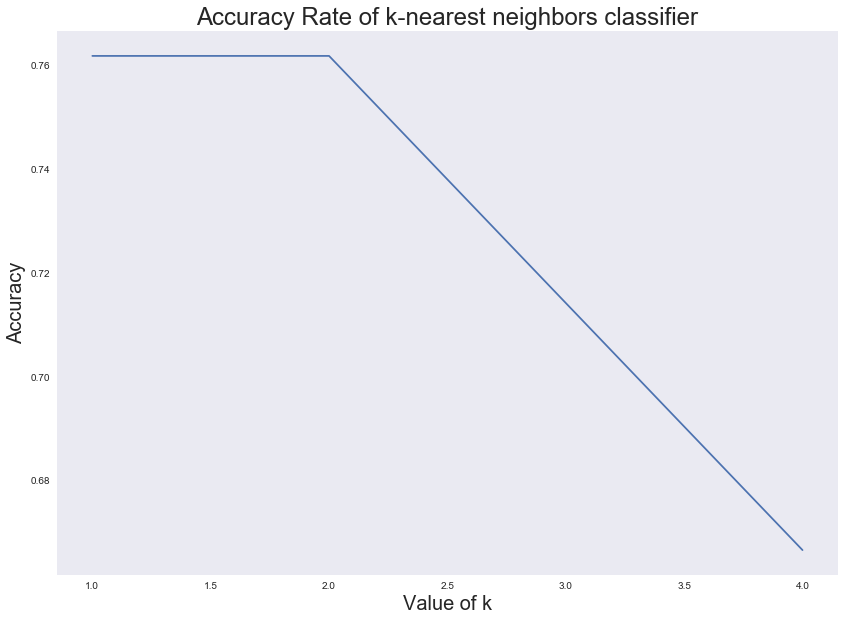

In [33]:
import matplotlib.pyplot as plt 
%matplotlib inline

fig = plt.figure(figsize=(12, 8))
plt.plot([k for k in range(1, 5)], [k_accuracy[k] for k in range(1, 5)])
plt.title('Accuracy Rate of k-nearest neighbors classifier', fontsize=24)
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Value of k', fontsize=20)
fig.set_size_inches(14, 10, forward=True)
fig.savefig('fig/knn_hyperparam.png', dpi=100); 

The best model is thus $k = 1$, although only with a classification accuracy of 76%.

## Discussion

The assumption in our model before was that Presidents tend to give similar speeches over time, and so the vectors corresponding to their speeches were closer together in $\mathbb{R}^{n}$ than the vectors corresponding to the speeches of another President. Therefore, one reason for misclassification might be that a President gave *substantially different* speeches over time, and so the nearest neighbors of a test point are not actually the same as the President. 

For example, George W. Bush might have given very different speeches before and after 9/11. Therefore, if we train on Bush's post-9/11 speeches, then the classifier wouldn't predict his pre 9/11 speeches very well, and might classify them as some other president. 

This deserves further analysis and exploration. For now, we'll look at which Presidents got misclassified, out of curiosity.

### Finding the misclassified Presidents 

We've found that the best $k$ is $k = 1$. Now, let's look at which Presidents get misclassified by the k-nearest neighors algorithm, even with the best k.

In [36]:
#    test_accuracy, misclassified_presidents = knn_train_and_predict(k, training_data, 
#training_data.index.values, test_data, test_data.index.values)

best_model = KNeighborsClassifier(n_neighbors=1, weights='distance', metric=JSdiv)
    
#fit the model on the training data   
best_model.fit(training_points, training_labels)

#predict on the test data
prediction = best_model.predict(test_points)

#compute accuracy rate 
test_accuracy, misclassified_presidents = accuracy_rate(prediction, test_labels)
print(misclassified_presidents)

['Woodrow Wilson', 'George Washington', 'Donald J. Trump', 'Abraham Lincoln', 'Chester A. Arthur', 'William H. Taft', 'Millard Fillmore', 'Zachary Taylor', 'William Mckinley', 'Ulysses S. Grant']
